In [1]:
import pickle
import joblib
import matplotlib.pyplot as plt
# Daten laden
with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load(f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load(f)
with open('short_train_df.pkl', 'rb') as f:
    short_train_df = pickle.load(f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)
with open('short_test_df.pkl', 'rb') as f:
    short_test_df = pickle.load(f)
min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

In [1]:
import importlib.metadata as m

print("interpret:", m.version("interpret"))
print("scikit-learn:", m.version("scikit-learn"))
print("xgboost:", m.version("xgboost"))
print("igann:", m.version("igann"))
print("prophet:", m.version("prophet"))  # oder 'fbprophet', wenn alt
print("pygam:", m.version("pygam"))


interpret: 0.6.10
scikit-learn: 1.6.1
xgboost: 3.0.0
igann: 0.1.7
prophet: 1.1.6
pygam: 0.9.1


### Naive

Naive Forecast – MAE: 1.1426, RMSE: 2.6867, R²: 0.9294


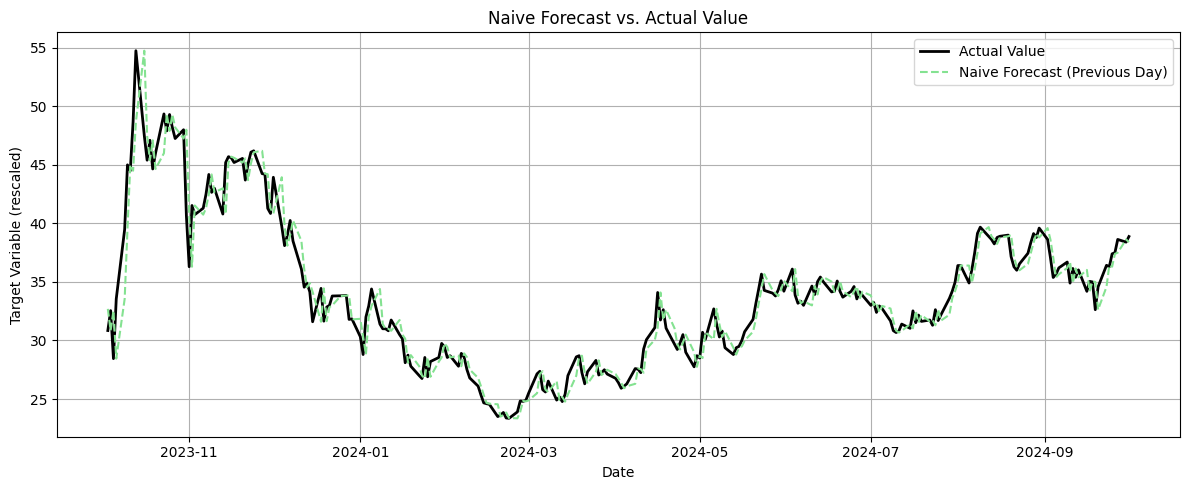

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Beispiel: test_y_df ist dein Holdout-Set (tägliche Zielwerte)
# y_train ist dein Trainings-Set
# Wichtig: Beide sollten ein datetime-index haben oder korrekt ausgerichtet sein.

# Naiver Forecast: ŷ(t) = y(t-1)
# Wir nehmen einfach den letzten Wert aus dem Training als Startpunkt
y_pred = test_y_df.shift(1)  # Vortageswert als Prognose

# Optional: Falls der erste Wert NaN wird, weil kein Vortag existiert, diesen entfernen
valid_idx = y_pred.dropna().index
y_true_valid = test_y_df.loc[valid_idx]
y_pred_valid = y_pred.loc[valid_idx]

# Evaluation
y_true_rescaled = y_min_max_scaler.inverse_transform(y_true_valid.values.reshape(-1, 1)).flatten()
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred_valid.values.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
rmse = mean_squared_error(y_true_rescaled, y_pred_rescaled)  # direkt RMSE
r2 = r2_score(y_true_rescaled, y_pred_rescaled)


print(f"Naive Forecast – MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
plt.figure(figsize=(12, 5))
plt.plot(valid_idx, y_true_rescaled, label="Actual Value", color="black", linewidth=2)
plt.plot(valid_idx, y_pred_rescaled, label="Naive Forecast (Previous Day)", color="#84E291", linestyle="--")
plt.title("Naive Forecast vs. Actual Value")
plt.xlabel("Date")
plt.ylabel("Target Variable (rescaled)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Lineare Regression

#### LR mit ganz


In [6]:
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 0. Nur numerische Spalten behalten (CatBoost & LinearRegression vertragen keine Datumswerte direkt)
train_df_clean = train_df.select_dtypes(exclude=['datetime64[ns]'])
test_df_clean = test_df.select_dtypes(exclude=['datetime64[ns]'])

top_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

# 4. Modell mit ausgewählten Features trainieren
linreg = LinearRegression()
linreg.fit(train_df_clean[top_features], train_y_df.values.ravel())

# 5. Vorhersage auf Testdaten
y_pred = linreg.predict(test_df_clean[top_features])

# 6. Rückskalierung der Vorhersagen
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# 7. Rückskalierung der echten Werte
test_y_array = test_y_df.values
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_array.reshape(-1, 1)).flatten()

# 8. Metriken berechnen
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

# 9. Ausgabe
print(f"MAE auf Holdout-Set (Originalskala): {mae:.4f}")
print(f"RMSE auf Holdout-Set (Originalskala): {rmse:.4f}")
print(f"R² auf Holdout-Set (Originalskala): {r2:.4f}")


MAE auf Holdout-Set (Originalskala): 1.8414
RMSE auf Holdout-Set (Originalskala): 2.4303
R² auf Holdout-Set (Originalskala): 0.8443


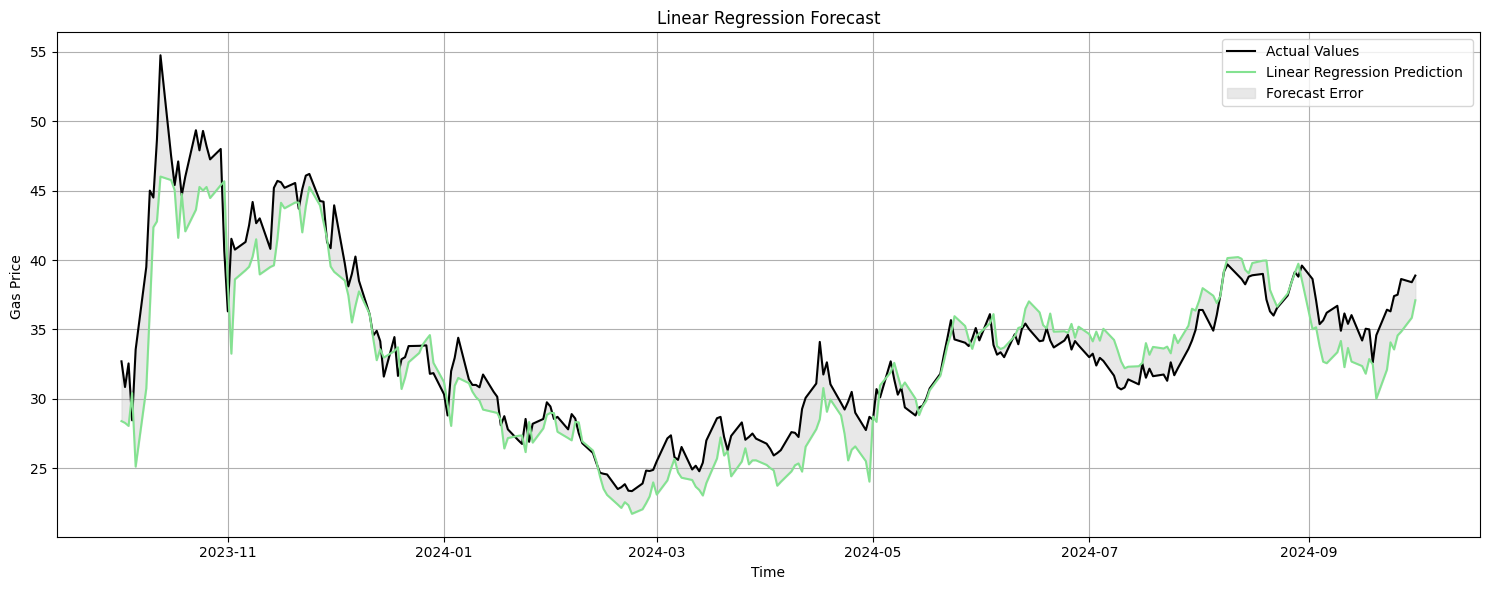

In [7]:
# Berechne die Prognosefehler
errors = y_pred_rescaled - y_holdout_rescaled

# Plot of actual values, predictions, and forecast error
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values ', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='Linear Regression Prediction ', color='#84E291')
plt.fill_between(test_y_df.index, y_holdout_rescaled, y_pred_rescaled, color='lightgrey', alpha=0.5, label='Forecast Error')
plt.title('Linear Regression Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
coef_series = pd.Series(linreg.coef_, index=top_features).sort_values()
coef_df = coef_series.reset_index()
coef_df.columns = ['Feature', 'Coefficient']
print(coef_df.to_csv(sep=';', index=False))


Feature;Coefficient
S-Coal Price (close)_rollmean_7;-0.04832427466578583
P-GPR_rollmean_30;-0.015266816710049888
Season_Winter;-0.013245811034758692
N-Demand LDZ_rollstd_30;-0.006643321874040586
P-European_News_Index_lag1;-0.004819137318363933
P-European_News_Index_rollmean_30;0.008298676915529895
N-Demand LDZ_rollmean_30;0.008327525955940263
K-Wind speed_rollmean_7;0.008935754799842781
P-GPR_lag1;0.009630865381882297
S-Coal Price (close)_rollstd_3;0.02813448131854216
S-Coal Price (close)_lag1;0.03839974286870446
S-Gas DA D;0.9477719885108998



### LASSO

Lasso – MAE: 1.1663
Lasso – RMSE: 1.6692
Lasso – R²: 0.9265

Lasso-Koeffizienten:
S-Gas DA D       0.932298
P-GPR_lag1       0.000412
Season_Winter   -0.005572
dtype: float64


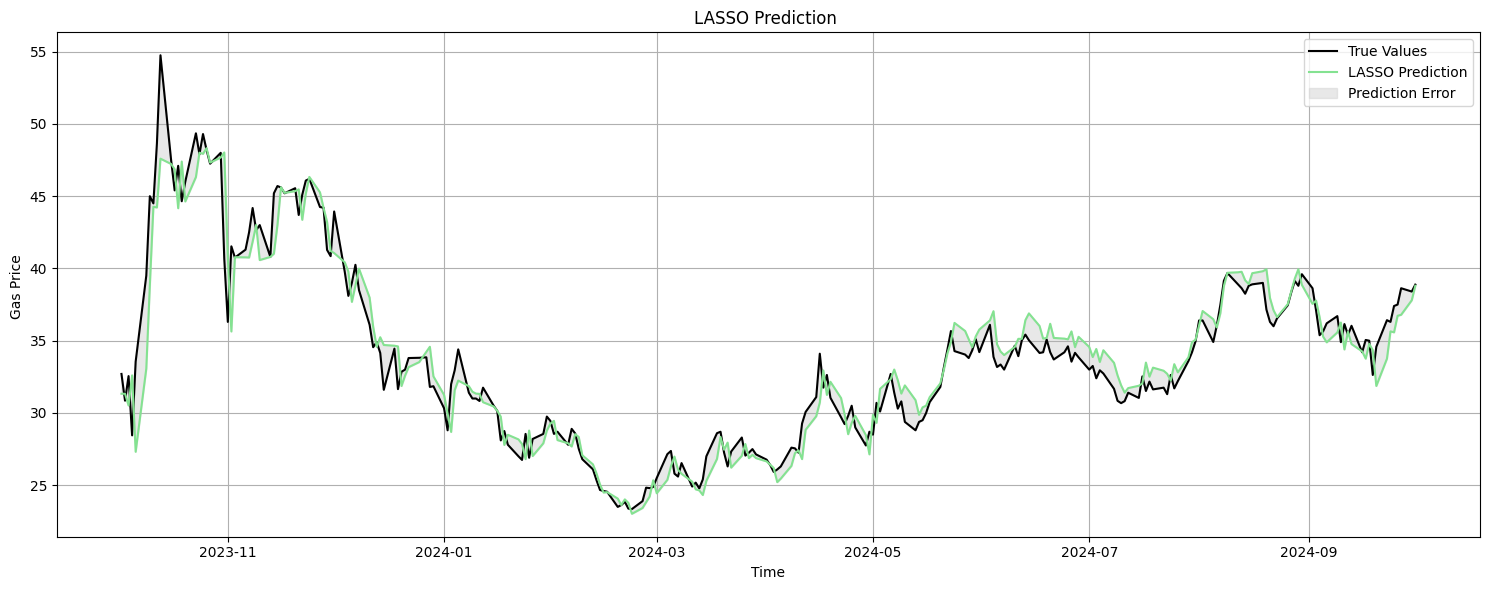

In [9]:
from sklearn.linear_model import LassoCV

# 0. Nur numerische Spalten behalten
train_df_clean = train_df.select_dtypes(exclude=['datetime64[ns]'])
test_df_clean = test_df.select_dtypes(exclude=['datetime64[ns]'])

top_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']
# 1. Modell mit Lasso (inkl. automatischer Alpha-Wahl per CV)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(train_df_clean[top_features], train_y_df.values.ravel())

# 2. Vorhersage auf Testdaten
y_pred = lasso.predict(test_df_clean[top_features])

# 3. Rückskalierung
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
test_y_array = test_y_df.values
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_array.reshape(-1, 1)).flatten()

# 4. Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

# 5. Ausgabe
print(f"Lasso – MAE: {mae:.4f}")
print(f"Lasso – RMSE: {rmse:.4f}")
print(f"Lasso – R²: {r2:.4f}")

# Optional: Gewichtungen anzeigen
lasso_weights = pd.Series(lasso.coef_, index=top_features)
print("\nLasso-Koeffizienten:")
print(lasso_weights[lasso_weights != 0].sort_values(ascending=False))

# Berechne die Prognosefehler
errors = y_pred_rescaled - y_holdout_rescaled

# Plot der echten Werte, Vorhersagen und Prognosefehler
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='True Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='LASSO Prediction', color='#84E291')
plt.fill_between(test_y_df.index, y_holdout_rescaled, y_pred_rescaled, color='lightgrey', alpha=0.5, label='Prediction Error')
plt.title('LASSO Prediction ')
plt.xlabel('Time')
plt.ylabel('Gas Price ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
